In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import LogStretch, MinMaxInterval, ImageNormalize
from astropy.wcs import WCS
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import scipy.stats as stats
from scipy.optimize import curve_fit

# data file is 
data_file = 'ic2r02050_drz.fits'


""" Note to Marker
Sure I could have added the +/- for the core radius but it wasnt asked and I am tired, addtionaly I could probably make
all the figures as a big subplot which would be nicer to look at."""

' Note to Marker\nSure I could have added the +/- for the core radius but it wasnt asked and I am tired, addtionaly I could probably make\nall the figures as a big subplot which would be nicer to look at.'

In [6]:
def read_fits_data(data_file):
    """
    Read data from a FITS file and return the data, nanmean, WCS, and header.

    Parameters:
        data_file (str): The path to the FITS file containing the data.

    Returns:
        tuple: A tuple containing the following elements:
            data, nanmean, wcs, header
            - data (2D array-like): The data extracted from the FITS file.
            - nanmean (float): The np.nanmean of the data before NaN values replaced by zeros.
            - wcs (WCS object): World Coordinate System information from the FITS header.
            - header (Header object): The header information extracted from the FITS file.

    This function reads data from a FITS file, specifically from the [1] extension. It computes the nanmean of the data
    and replaces NaN values with zeros. Additionally, it extracts the WCS (World Coordinate System) information
    and the header from the FITS file.

    Note:
    The function uses the Astropy library to work with FITS files and returns a tuple of data, nanmean, WCS, and header.
    """
    with fits.open(data_file) as hdulist:
        data = hdulist[1].data
        nanmean = np.nanmean(data)
        data = data
        data[np.isnan(data)] = np.zeros(np.shape(data))[np.isnan(data)]
        header =  hdulist[1].header
        wcs = WCS(header)

    return data, nanmean, wcs, header



def make_sky_image(data, wcs):
    """
    Create a plot of astronomical data projected onto sky coordinates.

    Parameters:
        data (2D array-like): The astronomical data to be plotted.
        wcs (WCS object): World Coordinate System information for the data.

    Returns:
        None

    This function generates a plot of astronomical data using a gray color scheme and logarithmic normalization.
    The plot is projected onto sky coordinates defined by the provided WCS (World Coordinate System) object.

    The plot includes labels for Right Ascension (RA) and Declination (DEC), a colorbar indicating intensity
    in a logarithmic scale, and a title describing the image.

    Note:
    The function displays the plot using Matplotlib and does not return any values. It sets the current figure for the plot.
    """

    # get some params for the norm
    stretch = LogStretch()
    interval = MinMaxInterval()
    norm = ImageNormalize(data, interval=interval, stretch=stretch, vmin=0)

    # make figure 
    fig = plt.figure(figsize=(12, 8), dpi=350)
    plt.subplot(projection=wcs)
    plt.imshow(data + nanmean, origin='lower', cmap='gray', norm=norm, )
    plt.colorbar(label='Intensity (Log Scale)')
    plt.xlabel('RA',size=15)
    plt.ylabel('DEC', size=15)
    plt.title('FITS Image with Log Stretch Normalization', size=15)


def find_sources(data, nanmean, snr_threshold, sigma=5, fwhm=3):
    """
    Find sources in an image using DAOStarFinder.

    Parameters:
        data (2D array-like): The image data in which sources are to be detected.
        nanmean (float): The mean value of the data, excluding NaN values.
        snr_threshold (float): Signal-to-noise ratio threshold for source detection.
        sigma (int, optional): Clipping factor for calculating statistics. Default is 5.
        fwhm (float, optional): Full-width at half-maximum of the sources. Default is 3.

    Returns:
        tuple: A tuple containing two arrays of x_centroids and y_centroids for the detected sources.

    This function uses the DAOStarFinder algorithm to find sources in the input image data. It calculates the mean,
    median, and standard deviation of the data, excluding NaN values. The SNR_threshold parameter sets the
    signal-to-noise ratio required for a source to be detected.

    The function returns two arrays, x_centroids and y_centroids, representing the pixel coordinates of the detected sources.
    """

    mean, median, std = sigma_clipped_stats(data, sigma=sigma)
    daofinder = DAOStarFinder(
        fwhm=fwhm,                
        threshold=(snr_threshold* std) + nanmean,     
        exclude_border=True       
    )
    sources = daofinder.find_stars(data)

    # Get x and y centroids of the detected stars
    x_centroids = sources['xcentroid']
    y_centroids = sources['ycentroid']

    return x_centroids, y_centroids


def gaussian(x, amplitude, mean, stddev, c):
    'Guassian function with added constant background (c)'
    return (amplitude * np.exp(-((x - mean)**2 / (2 * stddev ** 2)))) +c



def histogram_plots(x_centroids, y_centroids,):
    """
    Create histogram plots for source locations along the X and Y axes.

    Parameters:
        x_centroids (array-like): X-coordinates of source centroids.
        y_centroids (array-like): Y-coordinates of source centroids.

    Returns:
        tuple: A tuple containing the mean X and Y positions of the source centroids.

    This function generates two histogram plots to visualize the distribution of source positions along the X and Y axes.
    It fits a Gaussian curve to the histograms to estimate the mean position and returns these means as a tuple.

    The function displays both plots using Matplotlib and returns the calculated mean X and Y positions.
    """

    # x axis plot
    # Compute the histogram using np.histogram
    fig = plt.figure(figsize=(8, 6), dpi=100)
    hist, bins = np.histogram(x_centroids, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create the histogram 
    # fit gaussian 
    p0 = [np.max(hist), np.mean(bin_centers), np.std(hist), np.min(hist)]
    params, covariance = curve_fit(gaussian, xdata=bin_centers, ydata=hist, p0=p0)
    # Extract the fitted parameters & plot
    amplitude_fit, mean_fit, stddev_fit,c  = params

    plt.fill_between(bin_centers, gaussian(bin_centers, amplitude_fit, mean_fit, stddev_fit, c), alpha=0.5,  color='k',)
    plt.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', alpha=0.65, color='orchid',label='Data',zorder=1,)
    plt.plot(bin_centers, gaussian(bin_centers, amplitude_fit, mean_fit, stddev_fit, c), linestyle='--',  color='k', label='Gaussian', zorder=1, linewidth=2)

    x_mean = mean_fit
    plt.xlim(0,np.max(x_centroids))
    plt.title('Source Histogram X Axis', size=15)
    plt.ylabel('Number of Sources', size=15)
    plt.xlabel('X Pixel Position', size=15)
    legend = plt.legend(fontsize=15)
    legend.set_title("N = " + str(len(x_centroids)),prop={'size': 15})

    plt.show()

    # y axis plot
    # Compute the histogram using np.histogram
    fig = plt.figure(figsize=(8, 6), dpi=100)
    hist, bins = np.histogram(y_centroids, bins=100)  # Adjust the number of bins as needed
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create the histogram
    # fit gaussian 
    p0 = [np.max(hist), np.mean(bin_centers), np.std(hist), np.min(hist)]
    params, covariance = curve_fit(gaussian, xdata=bin_centers, ydata=hist, p0=p0)
    # Extract the fitted parameters & plot
    amplitude_fit, mean_fit, stddev_fit,c  = params
    plt.fill_between(bin_centers, gaussian(bin_centers, amplitude_fit, mean_fit, stddev_fit, c), alpha=0.5,  color='k',)
    plt.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', alpha=0.65, color='steelblue',label='Data',zorder=1)
    plt.plot(bin_centers, gaussian(bin_centers, amplitude_fit, mean_fit, stddev_fit, c), linestyle='--',  color='k', label='Gaussian', zorder=1, linewidth=2)

    y_mean = mean_fit

    plt.xlim(0,np.max(y_centroids))
    plt.title('Source Histogram Y Axis', size=15)
    plt.ylabel('Number of Sources', size=15)
    plt.xlabel('Y Pixel Position', size=15)
    legend = plt.legend(fontsize=15)
    legend.set_title("N = " + str(len(y_centroids)),prop={'size': 15})
    plt.show()

    return x_mean, y_mean



def king_model(r, a, gamma, n_0):
    """
    Fit the stellar density profile with a King model commonly used for globular clusters.

    Parameters:
        r (array-like): Radial distances at which to evaluate the King model.
        a (float): Radial scale-length.
        gamma (float): Power-law index.
        n_0 (float): Normalization at zero radius.

    Returns:
        array-like: Stellar density values evaluated at the given radial distances.

    The King model is used to describe the radial density profile of stars in globular clusters.
    The model's parameters include the radial scale-length (a), power-law index (gamma), and the
    normalization at zero radius (n_0).

    The function calculates the stellar density values based on the King model equation and returns
    an array of density values corresponding to the input radial distances.
    """

    return n_0*((1 + (r/a)**2)**(-0.5*gamma))


def source_location_plot_pix(x_centroids, x_mean, y_centroids, y_mean):
    """
    Create a pixel-based histogram plot of source locations relative to a center.

    Parameters:
        x_centroids (array-like): x-coordinates of source centroids.
        x_mean (float): Mean x-coordinate.
        y_centroids (array-like): y-coordinates of source centroids.
        y_mean (float): Mean y-coordinate.

    Returns:
        None

    This function generates a histogram plot to visualize the distribution of source locations in pixels coordinates
    relative to a specified center point defined by (x_mean, y_mean). The histogram represents the number of sources
    at different distances from the center. Cutoff is at 2000 pixels from center to avoid edge artifacts. 

    Note:
    The function displays the plot using Matplotlib and does not return any values. It sets the current figure for the plot.
    """

    fig = plt.figure(figsize=(8, 6), dpi=100)

    # calculate the square of the distance
    # _2 represents the square of a value
    source_distance_2 = (x_centroids-x_mean)**2 + (y_centroids-y_mean)**2

    # take the sqrt and make the histogram, use 100 bins, and cutout pixels further than 2000
    hist, bins = np.histogram(np.sqrt(source_distance_2)[np.sqrt(source_distance_2)<2000], bins=100)

    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', alpha=0.65, color='firebrick',label='Data',zorder=1)
    plt.title('Source Locations vs Distane From Center', size=15)
    plt.xlabel('Distance From Center (pix)', size=15)
    plt.ylabel('N Sources', size=15)
    plt.xlim(0, 2000)
    legend = plt.legend(fontsize=15)
    legend.set_title("N = " + str(len(y_centroids)),prop={'size': 15})
    plt.show()


def stellar_density_profile(x_centroids, x_mean, y_centroids, y_mean):
    """
    Calculate the stellar density profile and fit it with a King model.

    Parameters:
        x_centroids (array-like): x-coordinates of source centroids.
        x_mean (float): Mean x-coordinate. 
        y_centroids (array-like): y-coordinates of source centroids.
        y_mean (float): Mean y-coordinate.

    Returns:
        None

    This function computes the stellar density profile of sources around a central point defined by (x_mean, y_mean).
    It then fits the data to a King model and visualizes the results, including the King model fit and core radius.

    Note:
    The function generates a plot and does not return any values. It sets the current Matplotlib figure for the plot.
    """


    source_distance_2 = (x_centroids-x_mean)**2 + (y_centroids-y_mean)**2
    hist, bins = np.histogram(np.sqrt(source_distance_2)[np.sqrt(source_distance_2)<2000], bins=100)  # Adjust the number of bins as needed
    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_centers = bin_centers * 0.04 # now in arcseconds
    bins = bins* 0.04
    annulus_area = np.pi * (bins[1:]**2 -bins[:-1]**2) 
    stellar_density = (hist/ annulus_area)
    std_stellar_den = np.sqrt(hist) / annulus_area
    fig = plt.figure(figsize=(14, 6), dpi=100)
    plt.scatter((bin_centers), stellar_density, alpha=0.4, color='green',label='Data',zorder=1)
    plt.errorbar(bin_centers, stellar_density, yerr=std_stellar_den, fmt='none', ecolor='green', capsize=3,alpha=0.4)
    plt.title('Stellar Density Profile', size=15)
    plt.xlabel('Distance From Center (arcsec)', size=15)
    plt.ylabel('Sources Per (arcsec$^{-2}$)', size=15)
   

    # Perform the curve fit
    popt, pcov = curve_fit(king_model, xdata=bin_centers, ydata=stellar_density,
                               sigma=std_stellar_den, absolute_sigma=True)
    std_model_errors = np.sqrt(np.diag(pcov))


    plt.plot(bin_centers, king_model(bin_centers, *popt), color='k', linestyle='--', label="King Model")

    # Create the shaded region for the standard deviation
    x_fill = np.linspace(min(bin_centers), max(bin_centers), 100)
    popt_high = popt + std_model_errors
    popt_low = popt - std_model_errors
    y_upper = king_model(x_fill, *popt_high)
    y_lower = king_model(x_fill, *popt_low)

    plt.fill_between(x_fill, y_lower, y_upper, color='gray', alpha=0.5, )

    plt.yscale('log')
    plt.xscale('log')

    # calculate core radius
    a, gamma, n_0 = popt
    r_c = a*(2**(2*gamma) -1)**0.5
    legend = plt.legend(fontsize=15)
    legend.set_title("Core Radius is " + str(r_c)[:4] + '(Arcsec)',prop={'size': 15})



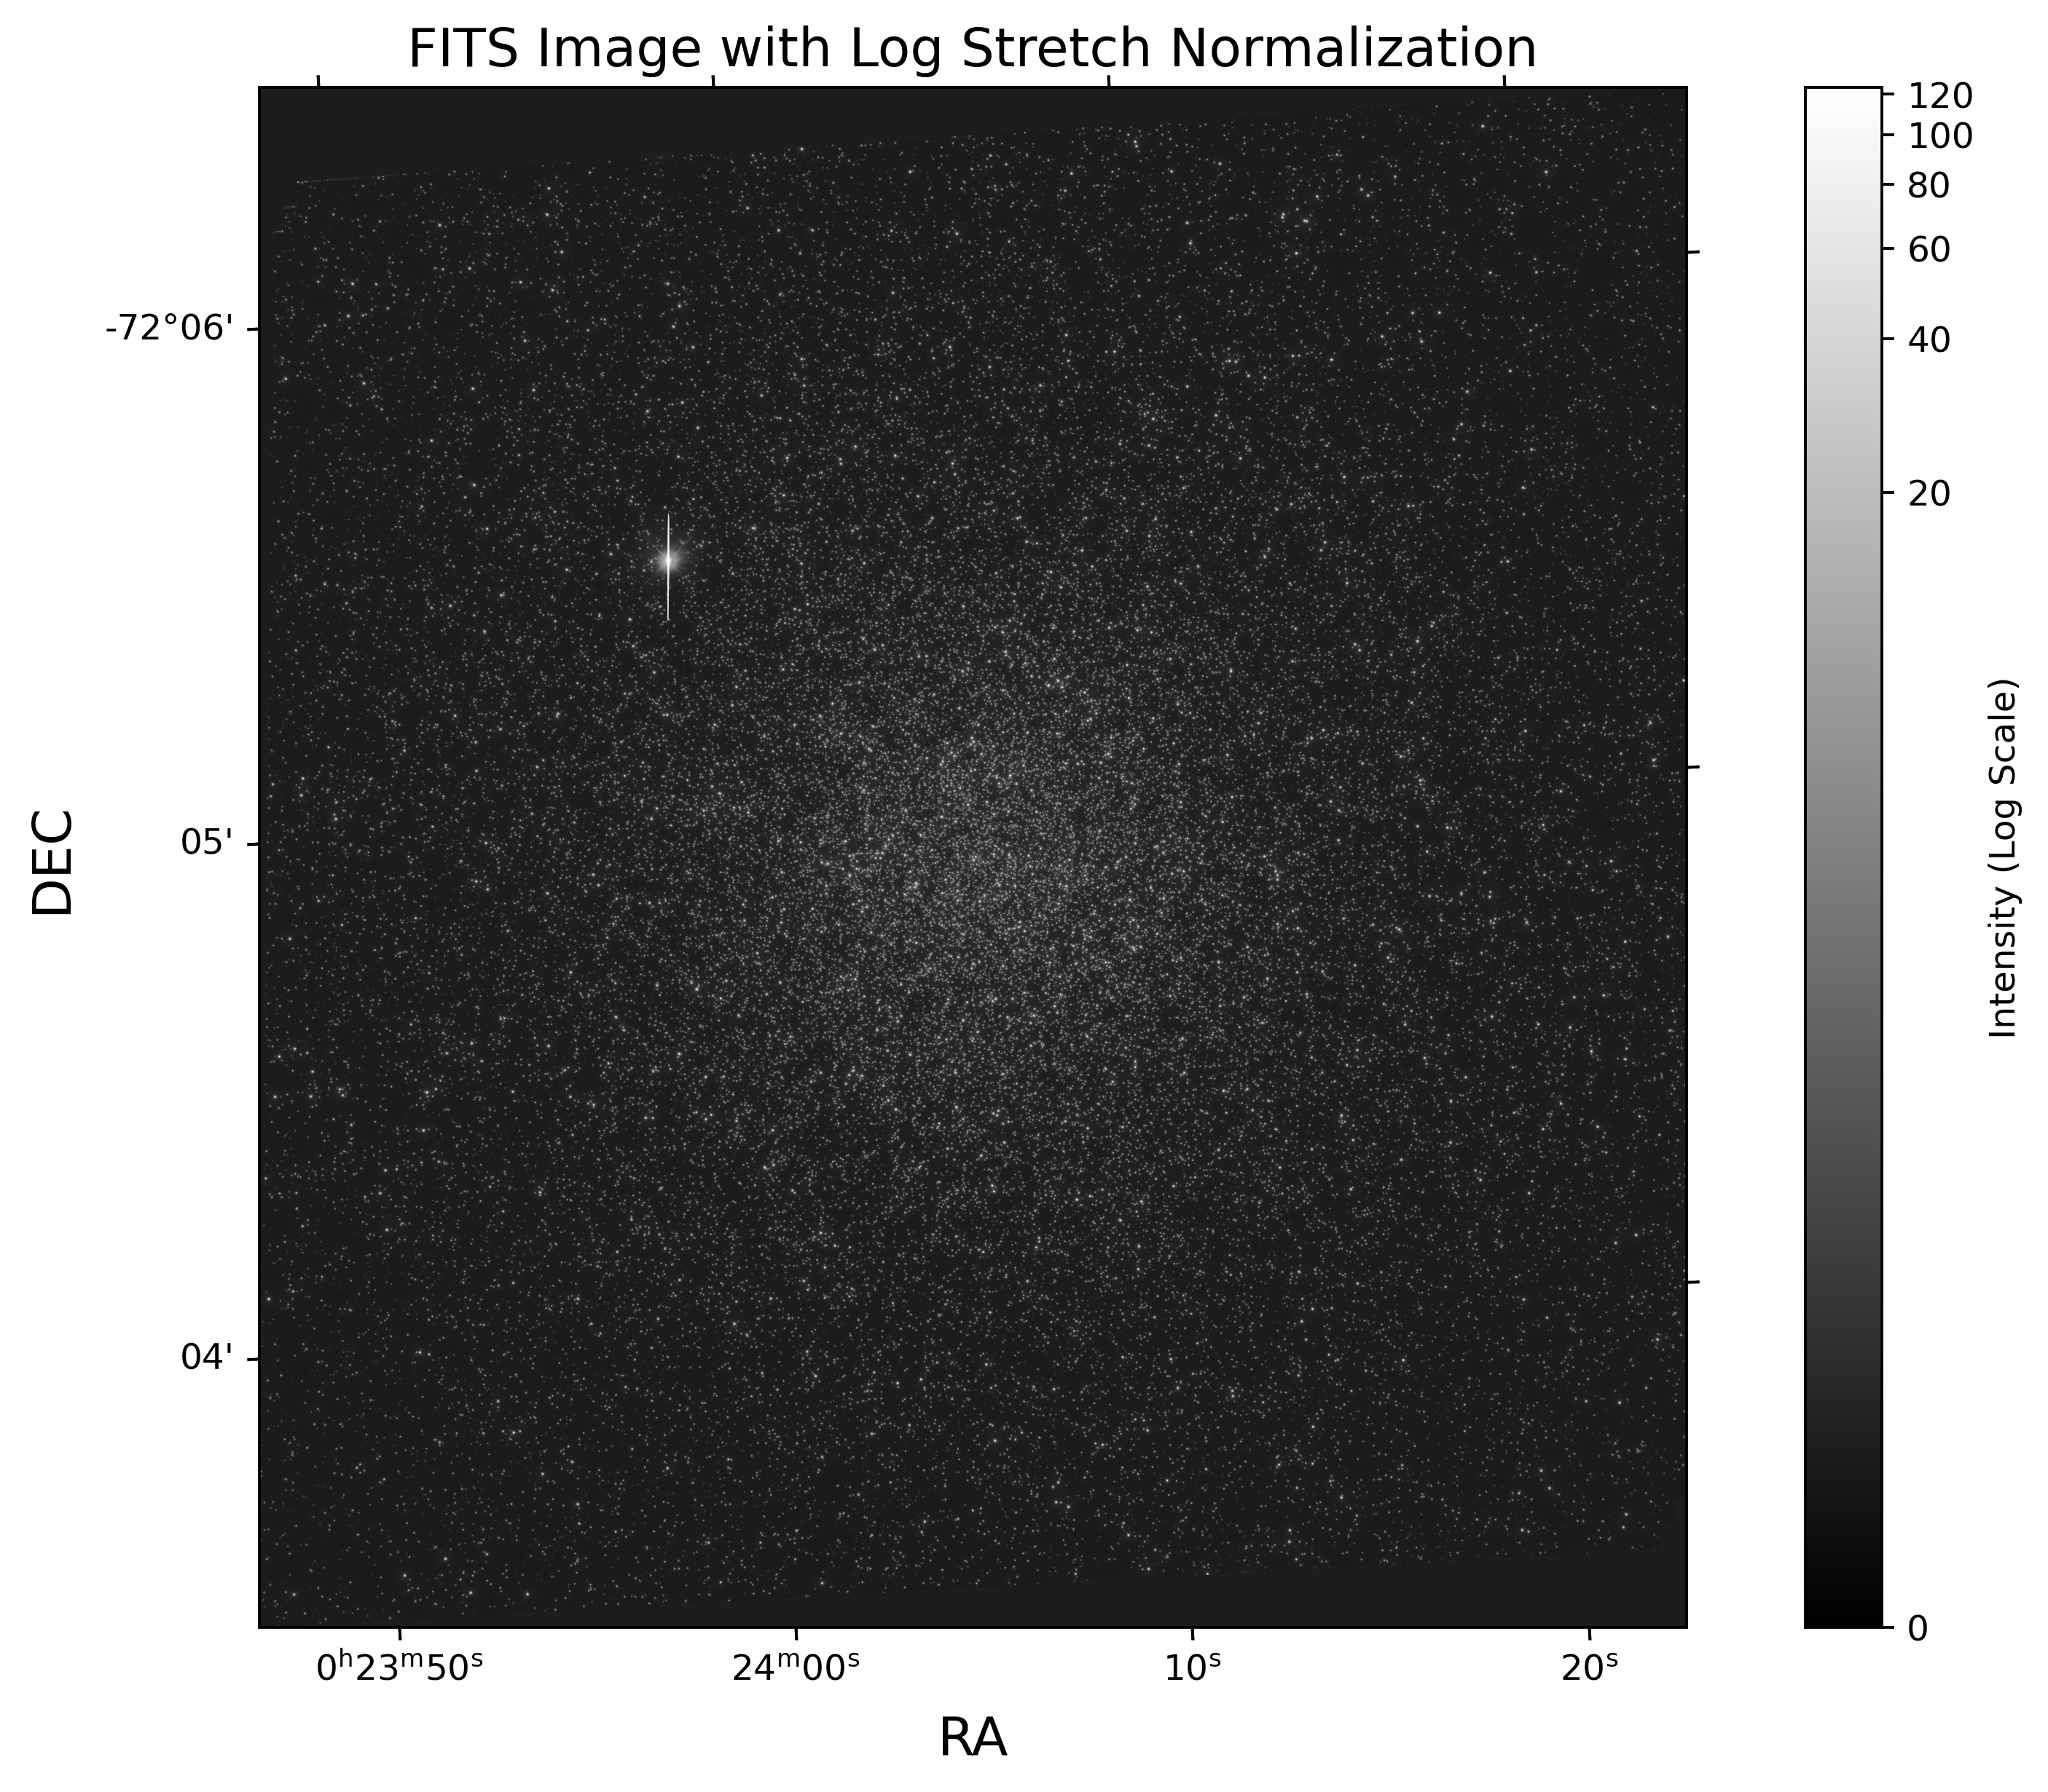

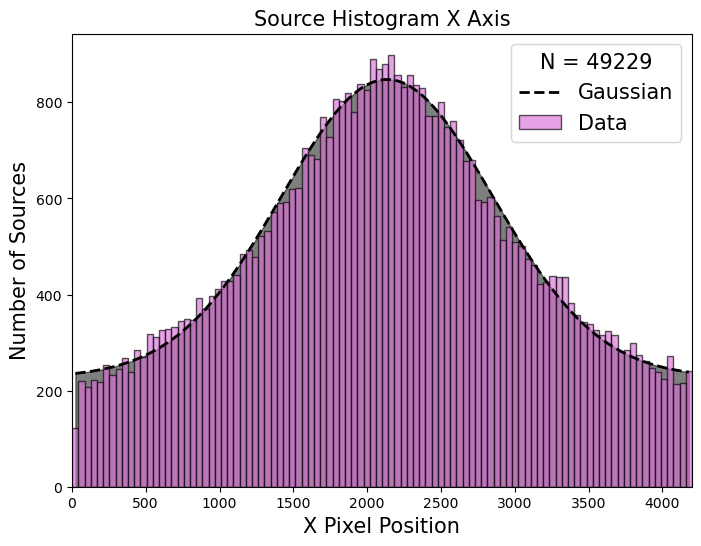

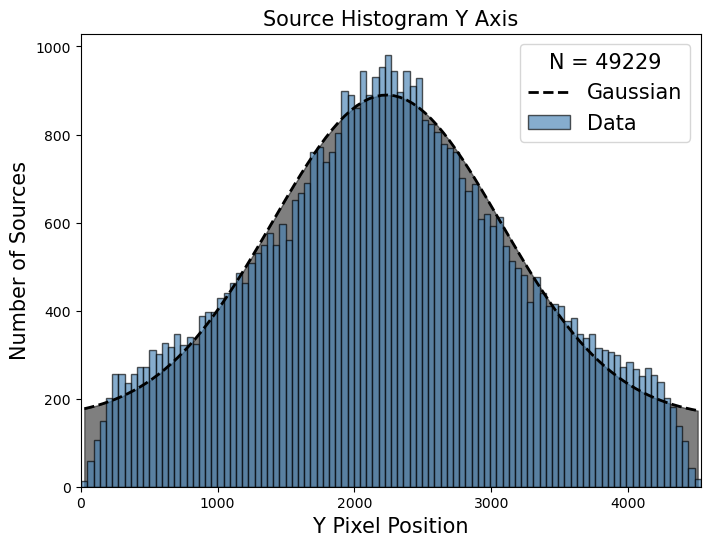

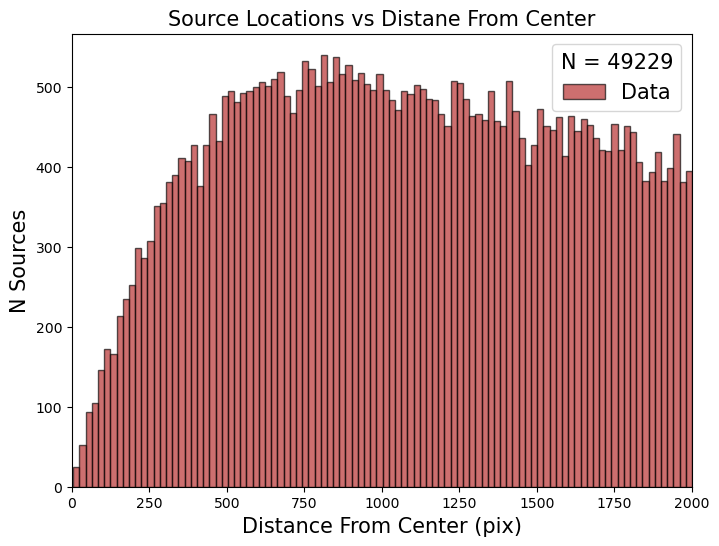

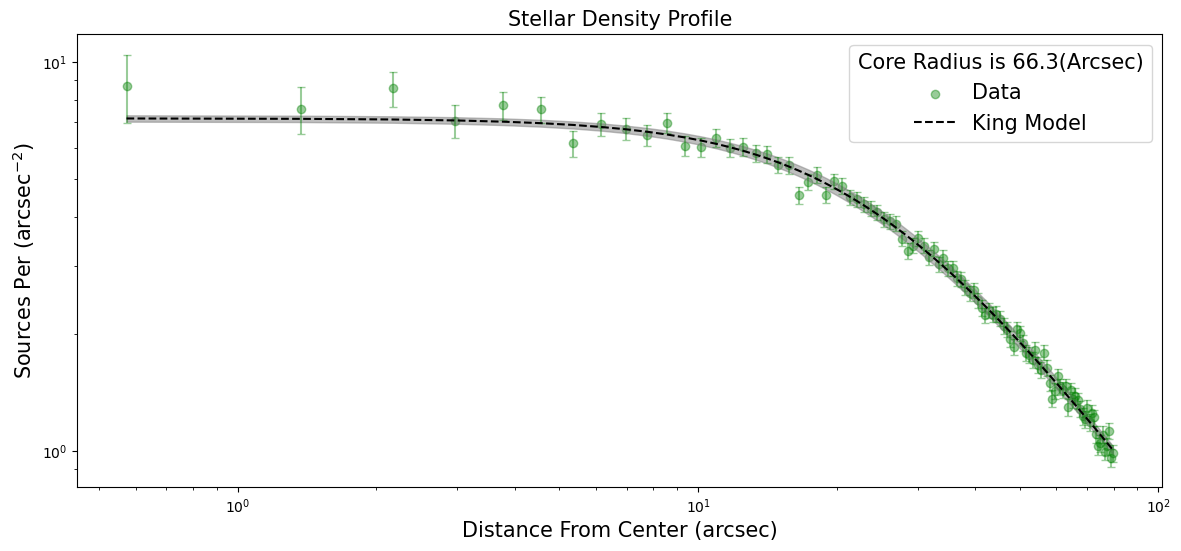

In [7]:
# lets go
snr_threshold = 5
data, nanmean, wcs, header = read_fits_data(data_file)
make_sky_image(data, wcs)
x_centroids, y_centroids = find_sources(data, nanmean, snr_threshold, sigma=5)
x_mean, y_mean = histogram_plots(x_centroids, y_centroids,)
source_location_plot_pix(x_centroids, x_mean, y_centroids, y_mean)
stellar_density_profile(x_centroids, x_mean, y_centroids, y_mean)

